# Document Overview

**Purpose:**
Training and Evaluating the Model (single category)

**Input file:** 
1. Model input data: './np_save/sample_sets.npy'
2. POI_cat_distrib : './np_save/poi_cat_distrib.npy'
3. POI distance matrix: './np_save/dist_mat.npy'
4. Maximum distance and sequence length: './np_save/max_dist.npy', './np_save/max_seq_len.npy'

**Output file:** 
tbd

**Creation Date:** 9th Nov 2019

In [1]:
# dependencies

import tensorflow as tf
import numpy as np
import random

In [2]:
# import custom library

import Helper_Functions as Helper

In [3]:
# import input data

# dir = './test_np_save_CAL/'
dir = './np_save_CAL/'

samples = Helper.load_dict(dir + 'sample_sets.pkl')
POI_cat_distrib = Helper.load_dict(dir + 'poi_cat_distrib.pkl')
dist_mat = np.load(dir + 'dist_mat.npy', allow_pickle=True)
poi_cat_specific_poi_dict = Helper.load_dict(dir + 'poi_cat_specific_poi_dict.pkl')

POI_reIndex_mapping = np.load(dir + 'POI_reIndex_mapping.npy', allow_pickle=True)
user_reIndex_mapping = np.load(dir + 'user_reIndex_mapping.npy', allow_pickle=True)
cat_reIndex_mapping = np.load(dir + 'cat_reIndex_mapping.npy', allow_pickle=True)

max_dist = np.load(dir + 'max_dist.npy', allow_pickle=True)
max_seq_len = np.load(dir + 'max_seq_len.npy', allow_pickle=True)
neg_num = np.load(dir + 'neg_sample_num.npy', allow_pickle=True)

In [4]:
samples

{0: [([142, 140, 141],
   [0, 1, 1],
   [1, 1, 1],
   [0, 0, 0],
   [12, 29, 13],
   [141, 140, 132, 179, 177, 176, 77, 65, 74],
   [916, 915, 892, 1181, 1177, 1174, 512, 474, 509],
   [[213, -1, 1], [144, 64, 0], [143, 1, 0], [166, 1, 0], [167, 1, 0]]),
  ([142, 140, 141, 140],
   [0, 1, 1, 1],
   [1, 1, 1, 16],
   [0, 0, 0, 0],
   [12, 29, 13, 29],
   [140, 132, 179, 177, 176, 77, 65, 74],
   [915, 892, 1181, 1177, 1174, 512, 474, 509],
   [[213, -1, 1], [144, 64, 0], [143, 1, 0], [166, 1, 0], [167, 1, 0]]),
  ([142, 140, 141, 140, 132],
   [0, 1, 1, 1, 1],
   [1, 1, 1, 16, 16],
   [0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43],
   [132, 179, 177, 176, 77, 65, 74],
   [892, 1181, 1177, 1174, 512, 474, 509],
   [[213, -1, 1], [167, 1, 0], [139, 11, 0], [138, 52, 0], [137, 9, 0]]),
  ([142, 140, 141, 140, 132, 179],
   [0, 1, 1, 1, 1, 6],
   [1, 1, 1, 16, 16, 18],
   [0, 0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43, 12],
   [179, 177, 176, 77, 65, 74],
   [1181, 1177, 1174, 512, 474, 509],
   [[21

# 1. Set Hyper Parameter

In [5]:
# set hyper parameter

# sampling parameter
train_portion = 0.9
np_rand_seed = 2019
np.random.seed(np_rand_seed)
random.seed(2019)

# model parameter
RNN_stack_layers = 3
hidden_size = 300

# training parameter
batch_size = 1
lr = 1e-4
iter_num = 1000
break_threshold = 0.001

# overfit control
keep_prob = 0.1
reg_beta = 0.0025

# embedding size
poi_size = len(POI_reIndex_mapping)
dist_size = 100 #max_dist + 1
time_size = 24
user_size = len(user_reIndex_mapping)
cat_size = len(cat_reIndex_mapping) + 1

# Prepare Train Test Set

In [6]:
# train test split after shuffling

all_samples = []

for key in samples.keys():
    
    user_samples = samples[key]
    
    random.shuffle(user_samples)
    
    all_samples.append(user_samples)

all_samples

[[([177, 193, 116, 142],
   [0, 1, 1, 6],
   [1, 1, 2, 13],
   [0, 1, 0, 0],
   [17, 27, 47, 12],
   [142],
   [917],
   [[213, -1, 1], [143, 1, 0], [165, 16, 0], [166, 1, 0], [167, 1, 0]]),
  ([142, 140, 141],
   [0, 1, 1],
   [1, 1, 1],
   [0, 0, 0],
   [12, 29, 13],
   [141, 140, 132, 179, 177, 176, 77, 65, 74],
   [916, 915, 892, 1181, 1177, 1174, 512, 474, 509],
   [[213, -1, 1], [144, 64, 0], [143, 1, 0], [166, 1, 0], [167, 1, 0]]),
  ([142, 140, 141, 140, 132, 179, 177, 176, 77, 65, 74],
   [0, 1, 1, 1, 1, 6, 1, 1, 2, 2, 1],
   [1, 1, 1, 16, 16, 18, 18, 18, 19, 19, 19],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43, 12, 17, 1, 76, 7, 17],
   [74],
   [509],
   [[106, 33, 0], [131, 12, 0], [133, 46, 0], [134, 21, 0], [135, 2, 0]]),
  ([142, 140, 141, 140, 132, 179, 177, 176, 77],
   [0, 1, 1, 1, 1, 6, 1, 1, 2],
   [1, 1, 1, 16, 16, 18, 18, 18, 19],
   [0, 0, 0, 0, 0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43, 12, 17, 1, 76],
   [77, 65, 74],
   [512, 474, 509],
   [[106,

In [7]:
# split train test samples

all_training_samples, all_testing_samples = [], []

for user_samples in all_samples:

    N = len(user_samples)
    train_test_boundary = int(train_portion*N)

    all_training_samples.append(user_samples[:train_test_boundary])
    all_testing_samples.append(user_samples[train_test_boundary:])

In [8]:
all_training_samples

[[([177, 193, 116, 142],
   [0, 1, 1, 6],
   [1, 1, 2, 13],
   [0, 1, 0, 0],
   [17, 27, 47, 12],
   [142],
   [917],
   [[213, -1, 1], [143, 1, 0], [165, 16, 0], [166, 1, 0], [167, 1, 0]]),
  ([142, 140, 141],
   [0, 1, 1],
   [1, 1, 1],
   [0, 0, 0],
   [12, 29, 13],
   [141, 140, 132, 179, 177, 176, 77, 65, 74],
   [916, 915, 892, 1181, 1177, 1174, 512, 474, 509],
   [[213, -1, 1], [144, 64, 0], [143, 1, 0], [166, 1, 0], [167, 1, 0]]),
  ([142, 140, 141, 140, 132, 179, 177, 176, 77, 65, 74],
   [0, 1, 1, 1, 1, 6, 1, 1, 2, 2, 1],
   [1, 1, 1, 16, 16, 18, 18, 18, 19, 19, 19],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43, 12, 17, 1, 76, 7, 17],
   [74],
   [509],
   [[106, 33, 0], [131, 12, 0], [133, 46, 0], [134, 21, 0], [135, 2, 0]]),
  ([142, 140, 141, 140, 132, 179, 177, 176, 77],
   [0, 1, 1, 1, 1, 6, 1, 1, 2],
   [1, 1, 1, 16, 16, 18, 18, 18, 19],
   [0, 0, 0, 0, 0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43, 12, 17, 1, 76],
   [77, 65, 74],
   [512, 474, 509],
   [[106,

In [9]:
all_testing_samples

[[([186, 170, 177],
   [0, 1, 1],
   [14, 23, 23],
   [0, 0, 0],
   [12, 31, 17],
   [177],
   [1177],
   [[213, -1, 1], [192, -1, 1], [191, 25, 0], [190, 3, 0], [189, 16, 0]]),
  ([142, 140, 141, 140, 132, 179, 177],
   [0, 1, 1, 1, 1, 6, 1],
   [1, 1, 1, 16, 16, 18, 18],
   [0, 0, 0, 0, 0, 0, 0],
   [12, 29, 13, 29, 43, 12, 17],
   [177, 176, 77, 65, 74],
   [1177, 1174, 512, 474, 509],
   [[213, -1, 1], [192, -1, 1], [191, 25, 0], [190, 3, 0], [189, 16, 0]])],
 [([161, 129],
   [0, 8],
   [18, 20],
   [0, 0],
   [46, 0],
   [129],
   [884],
   [[213, -1, 1], [141, 13, 0], [140, 29, 0], [139, 11, 0], [138, 52, 0]]),
  ([195, 161],
   [0, 2],
   [18, 18],
   [1, 0],
   [24, 46],
   [161],
   [1094],
   [[213, -1, 1], [183, 18, 0], [182, 17, 0], [181, 78, 0], [180, 1, 0]])],
 [([4, 3],
   [0, 1],
   [0, 4],
   [0, 0],
   [1, 3],
   [3],
   [53],
   [[106, 33, 0], [136, 50, 0], [137, 9, 0], [138, 52, 0], [139, 11, 0]])],
 [([112, 105],
   [0, 6],
   [6, 17],
   [0, 0],
   [51, 58],
   [

In [10]:
def generate_cat_vec_seq(poi_seq, type_seq, cat_seq, POI_cat_distrib):
    
    cat_vec_seq = np.zeros([len(cat_seq), len(cat_reIndex_mapping)])
    
    for visit in range(len(type_seq)):
        
        if type_seq[visit] == 0:
            cat_vec_seq[visit][cat_seq[visit]] = 1
            
        else: # collective
            total_store = sum(POI_cat_distrib[poi_seq[visit]].values())
            
            for cat in POI_cat_distrib[poi_seq[visit]].keys():
                cat_vec_seq[visit][cat] = POI_cat_distrib[poi_seq[visit]][cat] / total_store
                
    return cat_vec_seq # [seq_len, cat_size]

In [11]:
def generate_cat_seq(cat_seq):
    
    return_seq = cat_seq
        
    if cat_seq == -1:
        return_seq = len(cat_reIndex_mapping)
        
    return return_seq

In [12]:
# generate training sample

def data_feeder(sample):
    
    feed_dict = {}
    
    poi_x = sample[0][:-1]
    poi_y = sample[0][-1]
    dist_x = sample[1][:-1]
    dist_y = sample[1][-1]
    time_x = sample[2][:-1]
    time_y = sample[2][-1]
    type_x = sample[3][:-1]
    type_y = sample[3][-1]
    cat_x = sample[4][:-1]
    cat_y = sample[4][-1]
    ground_truth = sample[5]
    true_spec_poi = sample[6]
    
    poi_neg = []
    type_neg = []
    cat_neg = []
    dist_neg = []
    time_neg = []
    for neg_sample in sample[7]:
        poi_neg.append(neg_sample[0])
        type_neg.append(neg_sample[2])
        cat_neg.append(generate_cat_seq(neg_sample[1]))
        dist_neg.append(dist_mat[neg_sample[0]][poi_y])
        time_neg.append(time_y)
    
    feed_dict['x_poi'] = [poi_x]
    feed_dict['x_dist'] = [dist_x]
    feed_dict['x_time'] = [time_x]
    feed_dict['x_type'] = [type_x]
    feed_dict['x_cat'] = [cat_x]
    
    feed_dict['y_poi'] = [[poi_y]]
    feed_dict['y_dist'] = [[dist_y]]
    feed_dict['y_time'] = [[time_y]]
    feed_dict['y_type'] = [[type_y]]
    feed_dict['y_cat'] = [[cat_y]]
    feed_dict['true_y_cat'] = [[sample[4][-1]]] # for evaluation
    feed_dict['ground_truth_set'] = [ground_truth]
    feed_dict['true_spec_poi'] = [true_spec_poi]
    
    feed_dict['neg_poi'] = [poi_neg]
    feed_dict['neg_dist'] = [dist_neg]
    feed_dict['neg_time'] = [time_neg]
    feed_dict['neg_type'] = [type_neg]
    feed_dict['neg_cat'] = [cat_neg]
    
    return feed_dict

# 2. Construct Model

## Placeholders

In [13]:
x_poi = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_dist = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_time = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_type = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]
x_cat = tf.placeholder(tf.int32, shape = [None, None]) # [batch, seq_len]

y_poi = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_dist = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_time = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_type = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
y_cat = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
true_y_cat = tf.placeholder(tf.int32, shape = [None, 1]) # [batch, seq_len]
saved_user_rep = tf.placeholder(tf.float32, shape = [None, 1, hidden_size]) # dynamic user represenation for testing
ground_truth_set = tf.placeholder(tf.int32, shape = [None, None]) # [batch, multiple_gound_truth_len]
prediction_set = tf.placeholder(tf.int32, shape = [None, None]) # [batch, multiple_prediction_len]

neg_poi = tf.placeholder(tf.int32, [None, neg_num]) # [batch, neg_len]
neg_dist = tf.placeholder(tf.int32, [None, neg_num]) # [batch, neg_len]
neg_time = tf.placeholder(tf.int32, [None, neg_num]) # [batch, neg_len]
neg_type = tf.placeholder(tf.int32, [None, neg_num]) # [batch, neg_len]
neg_cat = tf.placeholder(tf.int32, [None, neg_num]) # [batch, neg_len]

## Variables

In [14]:
# embeddings
user_emb = tf.Variable(tf.random_uniform([user_size, hidden_size], -1.0, 1.0))
poi_emb = tf.Variable(tf.random_uniform([poi_size, hidden_size], -1.0, 1.0))
cat_emb = tf.Variable(tf.random_uniform([cat_size, hidden_size], -1.0, 1.0))
type_emb = tf.Variable(tf.random_uniform([2, hidden_size], -1.0, 1.0))
time_emb = tf.Variable(tf.random_uniform([time_size, hidden_size], -1.0, 1.0))
dist_emb = tf.Variable(tf.random_uniform([dist_size, hidden_size], -1.0, 1.0))

# weights
init_weight = tf.truncated_normal([hidden_size, hidden_size], stddev = 1.0/np.sqrt(hidden_size))
W_poi = tf.Variable(init_weight)
W_time = tf.Variable(init_weight)
W_cat = tf.Variable(init_weight)
W_type = tf.Variable(init_weight)
W_dist = tf.Variable(init_weight)

W_h_c = tf.Variable(init_weight)
W_h_t = tf.Variable(tf.truncated_normal([1, hidden_size], stddev = 1.0/np.sqrt(hidden_size)))
W_h_p = tf.Variable(tf.truncated_normal([hidden_size*2, hidden_size], stddev = 1.0/np.sqrt(hidden_size)))

Instructions for updating:
Colocations handled automatically by placer.


## RNN Module

In [15]:
# x inputs

#----------------------------------------------

# left x inputs: user intension - category, time, type

input_x_cat = tf.nn.embedding_lookup(cat_emb, x_cat) # [batch, seq_len, dim]
input_x_time = tf.nn.embedding_lookup(time_emb, x_time) # [batch, seq_len, dim]
input_x_type = tf.nn.embedding_lookup(type_emb, x_type) # [batch, seq_len, dim]

inputs_x_l = tf.matmul(input_x_time, tf.expand_dims(W_time,0)) + tf.matmul(input_x_cat, tf.expand_dims(W_cat,0)) + tf.matmul(input_x_type, tf.expand_dims(W_type,0)) # [batch, seq_len, dim]

#----------------------------------------------

# right x inputs: poi prediction - poi, dist

input_x_dist = tf.nn.embedding_lookup(dist_emb, x_dist) # [batch, seq_len, dim]
input_x_poi = tf.nn.embedding_lookup(poi_emb, x_poi) # [batch, seq_len, dim]

inputs_x_r =  tf.matmul(input_x_dist, tf.expand_dims(W_dist,0)) + tf.matmul(input_x_poi, tf.expand_dims(W_poi,0)) # [batch, seq_len, dim]

In [16]:
# y inputs 

#----------------------------------------------

# left y inputs: user intension - category, time, type

input_y_cat = tf.nn.embedding_lookup(cat_emb, y_cat) # [batch, seq_len(1), dim]
input_y_time = tf.nn.embedding_lookup(time_emb, y_time) # [batch, seq_len(1), dim]
input_y_type = tf.nn.embedding_lookup(type_emb, y_type) # [batch, seq_len, dim]

inputs_y_l = tf.matmul(input_y_time, tf.expand_dims(W_time,0)) + tf.matmul(input_y_cat, tf.expand_dims(W_cat,0)) + tf.matmul(input_y_type, tf.expand_dims(W_type,0)) # [batch, seq_len(1), dim]

#----------------------------------------------

# right x inputs: poi prediction - poi, dist

input_y_dist = tf.nn.embedding_lookup(dist_emb, y_dist) # [batch, seq_len(1), dim]
input_y_poi = tf.nn.embedding_lookup(poi_emb, y_poi) # [batch, seq_len(1), dim]

inputs_y_r = tf.matmul(input_y_dist, tf.expand_dims(W_dist,0)) + tf.matmul(input_y_poi, tf.expand_dims(W_poi,0)) # [batch, seq_len(1), dim]

In [17]:
# negative inputs 

#----------------------------------------------

# left neg inputs: user intension - category, type

input_neg_cat =tf.nn.embedding_lookup(cat_emb, neg_cat) # [batch, neg_num, dim]
input_neg_time = tf.nn.embedding_lookup(time_emb, y_time) # [batch, neg_num, dim]
input_neg_type = tf.nn.embedding_lookup(type_emb, neg_type) # [batch, neg_num, dim]

inputs_neg_l = tf.matmul(input_neg_time, tf.expand_dims(W_time,0)) + tf.matmul(input_neg_cat, tf.expand_dims(W_cat,0)) + tf.matmul(input_neg_type, tf.expand_dims(W_type,0))  # [batch, neg_num, dim]

#----------------------------------------------

# right neg inputs: poi prediction - poi, dist

input_neg_dist = tf.nn.embedding_lookup(dist_emb, neg_dist) # [batch, neg_num, dim]
input_neg_poi = tf.nn.embedding_lookup(poi_emb, neg_poi) # [batch, neg_num, dim]

inputs_neg_r = tf.matmul(input_neg_dist, tf.expand_dims(W_dist,0)) + tf.matmul(input_neg_poi, tf.expand_dims(W_poi,0)) # [batch, neg_num, dim]

In [18]:
# RNN model

# tf.reset_default_graph()

#----------------------------------------------

# left part - user intension

with tf.variable_scope("rnn_l"):
    cell_l = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, state_is_tuple=True)
    cell_l = tf.nn.rnn_cell.DropoutWrapper(cell_l, output_keep_prob=keep_prob)
    cell_l = tf.nn.rnn_cell.MultiRNNCell([cell_l] * RNN_stack_layers)
    initial_state_l = cell_l.zero_state(batch_size, tf.float32)

    outputs_l, states_l = tf.nn.dynamic_rnn(cell_l, inputs = inputs_x_l, initial_state = initial_state_l)

#----------------------------------------------

# right part - poi prediction

with tf.variable_scope("rnn_r"):
    cell_r = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, state_is_tuple=True)
    cell_r = tf.nn.rnn_cell.DropoutWrapper(cell_r, output_keep_prob=keep_prob)
    cell_r = tf.nn.rnn_cell.MultiRNNCell([cell_r] * RNN_stack_layers)
    initial_state_r = cell_r.zero_state(batch_size, tf.float32)

    outputs_r, states_r = tf.nn.dynamic_rnn(cell_r, inputs = inputs_x_r, initial_state = initial_state_r)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Loss and Optimiser 

### Training Part

In [19]:
# regularization (L2)

regularization = tf.nn.l2_loss(W_time) + tf.nn.l2_loss(W_cat) + tf.nn.l2_loss(cat_emb) + tf.nn.l2_loss(time_emb) + tf.nn.l2_loss(W_h_c) + tf.nn.l2_loss(W_h_t) + tf.nn.l2_loss(W_type) + tf.nn.l2_loss(type_emb) + tf.nn.l2_loss(W_dist) + tf.nn.l2_loss(dist_emb) + tf.nn.l2_loss(W_poi) + tf.nn.l2_loss(poi_emb) + tf.nn.l2_loss(W_h_p)

In [20]:
# loss 

#----------------------------------------------

# left loss: category and type prediction

final_output_l = tf.expand_dims(tf.transpose(outputs_l, [1, 0, 2])[-1], 1)  # [batch, 1, dim] # output original dim:[batch, seq_len, dim]

# category loss

output_h_c = tf.matmul(final_output_l, tf.expand_dims(W_h_c,0))

r_cat = tf.matmul(output_h_c, tf.transpose(inputs_y_l, [0, 2, 1])) # [batch, 1, 1]

r_cat_neg = tf.matmul(output_h_c, tf.transpose(inputs_neg_l, [0, 2, 1])) # [batch, 1, neg_num]

loss_cat = tf.reduce_sum(1 + tf.log(tf.exp(-(tf.tile(r_cat, [0, 0, neg_num]) - r_cat_neg)))) 

# type loss 

output_h_t = tf.matmul(final_output_l, tf.expand_dims(tf.transpose(W_h_t),0)) #[batch, 1, 1]

pred_t = tf.reduce_sum(tf.sigmoid(output_h_t)) #[batch, 1, 1]

loss_type = - (tf.cast(tf.reduce_sum(y_type), tf.float32) * tf.log(pred_t) + tf.cast((1-tf.reduce_sum(y_type)), tf.float32) * tf.log(1 - pred_t))

#----------------------------------------------

# right loss: poi prediction

final_output_r = tf.expand_dims(tf.transpose(outputs_r, [1, 0, 2])[-1], 1)  # [batch, 1, dim] # output original dim:[batch, seq_len, dim]

concat_ouput = tf.concat(axis = 2,values=[final_output_r, final_output_l]) # [batch, 1, dim*2]

# poi loss

output_h_p = tf.matmul(concat_ouput, tf.expand_dims(W_h_p,0)) #[batch, 1, dim]

r_poi = tf.matmul(output_h_p, tf.transpose(inputs_y_r, [0, 2, 1])) # [batch, 1, 1]

r_poi_neg = tf.matmul(output_h_p, tf.transpose(inputs_neg_r, [0, 2, 1])) # [batch, 1, neg_num]

loss_poi = tf.reduce_sum(tf.log(1 + tf.exp(-(tf.tile(r_poi, [0, 0, neg_num]) - r_poi_neg))))

#----------------------------------------------

# final loss

total_loss = loss_cat + loss_type + loss_poi + reg_beta * regularization

In [21]:
# modifier


# with gradient clipping 
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
gradients, variables = zip(*optimizer.compute_gradients(total_loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
train = optimizer.apply_gradients(zip(gradients, variables))

# train = tf.train.AdamOptimizer(learning_rate=lr).minimize(total_loss)

Instructions for updating:
Use tf.cast instead.


### Testing Part

In [22]:
# evaluation logit

final_output_l = tf.expand_dims(tf.transpose(outputs_l, [1, 0, 2])[-1], 1)  # [batch, 1, dim] # output original dim:[batch, seq_len, dim]

# cat logit

final_rep_cat = tf.matmul(final_output_l + saved_user_rep, tf.expand_dims(W_h_c,0))  # [batch, 1, dim]

all_cats = tf.matmul(tf.expand_dims(W_cat,0), tf.transpose(tf.expand_dims(cat_emb,0),[0,2,1])) # [batch, dim, cat_size]

logits_cat = tf.matmul(final_rep_cat, all_cats) # [batch, 1, cat_size]

# type logit

final_rep_type = tf.matmul(final_output_l + saved_user_rep, tf.transpose(tf.expand_dims(W_h_t,0),[0,2,1])) # [batch, 1, 1]

type_output = tf.sigmoid(final_rep_type) # [batch, 1, 1]

# poi logit

final_rep_poi = tf.matmul(concat_ouput, tf.expand_dims(W_h_p,0)) + saved_user_rep # [batch, 1, dim]

all_poi = tf.matmul(tf.expand_dims(W_poi,0), tf.transpose(tf.expand_dims(poi_emb,0),[0,2,1])) # [batch, dim, poi_size]

logits_poi = tf.matmul(final_rep_poi, all_poi) # [batch, 1, poi_size]

In [23]:
# evaluation category score: k = 1 

prediction_1_cat = tf.nn.top_k(logits_cat,1)[1]

expand_targets_1_cat = tf.tile(true_y_cat, [1, 1])

isequal_1_cat = tf.equal(expand_targets_1_cat, prediction_1_cat)

correct_prediction_1_cat = tf.reduce_sum(tf.cast(isequal_1_cat, tf.float32))

precison_1_cat = correct_prediction_1_cat / tf.cast(batch_size*1,tf.float32)

recall_1_cat = correct_prediction_1_cat / tf.cast(batch_size,tf.float32)

f1_1_cat = 2 * precison_1_cat * recall_1_cat / (precison_1_cat + recall_1_cat + 1e-10)

In [24]:
# evaluation category score: k = 5

prediction_5_cat = tf.nn.top_k(logits_cat,5)[1]

expand_targets_5_cat = tf.tile(true_y_cat, [1, 5])

isequal_5_cat = tf.equal(expand_targets_5_cat, prediction_5_cat)

correct_prediction_5_cat = tf.reduce_sum(tf.cast(isequal_5_cat, tf.float32))

precison_5_cat = correct_prediction_5_cat / tf.cast(batch_size*5,tf.float32)

recall_5_cat = correct_prediction_5_cat / tf.cast(batch_size,tf.float32)

f1_5_cat = 2 * precison_5_cat * recall_5_cat / (precison_5_cat + recall_5_cat + 1e-10)

In [25]:
# evaluation category score: k = 10

prediction_10_cat = tf.nn.top_k(logits_cat,10)[1]

expand_targets_10_cat = tf.tile(true_y_cat, [1, 10])

isequal_10_cat = tf.equal(expand_targets_10_cat, prediction_10_cat)

correct_prediction_10_cat = tf.reduce_sum(tf.cast(isequal_10_cat, tf.float32))

precison_10_cat = correct_prediction_10_cat / tf.cast(batch_size*10,tf.float32)

recall_10_cat = correct_prediction_10_cat / tf.cast(batch_size,tf.float32)

f1_10_cat = 2 * precison_10_cat * recall_10_cat / (precison_10_cat + recall_10_cat + 1e-10)

In [26]:
# evaluation type score

# prediction_type = tf.round(tf.cast(type_output, tf.int32)) # [batch, 1, 1]

prediction_type = tf.to_int32(type_output > 0.5)

isequal_type = tf.equal(tf.expand_dims(y_type,1), prediction_type) # [batch, 1, 1]

accuracy_type = tf.reduce_sum(tf.cast(isequal_type, tf.float32)) #single value

In [27]:
# evaluation poi score k = 1, 5, 10

prediction_1_poi = tf.nn.top_k(logits_poi,1)[1] # [batch, 1, 1]

prediction_5_poi = tf.nn.top_k(logits_poi,5)[1] # [batch, 1, 5]

prediction_10_poi = tf.nn.top_k(logits_poi,10)[1] # [batch, 1, 10]

expand_targets_poi = tf.expand_dims(ground_truth_set, 1) # [batch, 1, ?]

# common_poi = tf.sets.set_intersection(expand_targets_poi, tf.expand_dims(prediction_set, 1)) 

common_poi_1 = tf.sets.set_intersection(expand_targets_poi, prediction_1_poi) 

common_poi_5 = tf.sets.set_intersection(expand_targets_poi, prediction_5_poi) 

common_poi_10 = tf.sets.set_intersection(expand_targets_poi, prediction_10_poi) 

#  3. Run Model

In [28]:
samples[0][0]

([177, 193, 116, 142],
 [0, 1, 1, 6],
 [1, 1, 2, 13],
 [0, 1, 0, 0],
 [17, 27, 47, 12],
 [142],
 [917],
 [[213, -1, 1], [143, 1, 0], [165, 16, 0], [166, 1, 0], [167, 1, 0]])

In [29]:
def MAP_score(prediction, label):
    pred = prediction[0][0]
    true = label[0]
    visited_no = 0
    correct_no = 0
    total_sum = 0
    
    for guess in pred:
        visited_no += 1
        if guess in true:
            correct_no += 1
            total_sum += correct_no / visited_no
        
    return total_sum / len(label)
    
# end def

In [30]:
# training phase

saver = tf.train.Saver()
    
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    entropy_loss = []
    
    recall_10_poi = []
    
    prev_loss = 10000.0
    
    try: 
    
        for i in range(iter_num):

            user_counter = 0
            
            sample_counter = 0
            
            iter_total_loss = 0.0

            for user_training_samples in all_training_samples:

                for sample in user_training_samples:

                    feed_dict = data_feeder(sample)

                    _, _loss = sess.run([train, total_loss], 
                                        {x_time: feed_dict['x_time'], 
                                         x_cat: feed_dict['x_cat'], 
                                         x_type: feed_dict['x_type'],
                                         x_dist: feed_dict['x_dist'],
                                         x_poi: feed_dict['x_poi'],
                                         y_time: feed_dict['y_time'], 
                                         y_cat: feed_dict['y_cat'], 
                                         y_type: feed_dict['y_type'],
                                         y_dist: feed_dict['y_dist'],
                                         y_poi: feed_dict['y_poi'],
                                         neg_cat: feed_dict['neg_cat'],
                                         neg_type: feed_dict['neg_type'],
                                         neg_dist: feed_dict['neg_dist'],
                                         neg_poi: feed_dict['neg_poi']})

                    iter_total_loss += _loss
                    
                    sample_counter += 1
                    
                    # save user representation
                       
                    user_rep = sess.run(final_output_l, {x_time: feed_dict['x_time'], 
                                                x_cat: feed_dict['x_cat'], 
                                                x_type: feed_dict['x_type'],
                                                y_time: feed_dict['y_time'], 
                                                y_cat: feed_dict['y_cat'], 
                                                y_type: feed_dict['y_type'],
                                                neg_cat: feed_dict['neg_cat'],
                                                neg_type: feed_dict['neg_type']})

                    np.save('./user_rep_CAL/' + str(user_counter) + '_full.npy', user_rep)

                user_counter += 1
                
            avg_loss = iter_total_loss / sample_counter
            
            entropy_loss.append(avg_loss)
            
            # evaluating phase

            total_precision_1_cat = 0
            total_map_1_cat = 0
            total_recall_1_cat = 0
            total_f1_1_cat = 0
            total_f1_1_cat_map = 0

            total_precision_5_cat = 0
            total_map_5_cat = 0
            total_recall_5_cat = 0
            total_f1_5_cat = 0
            total_f1_5_cat_map = 0

            total_precision_10_cat = 0
            total_map_10_cat = 0
            total_recall_10_cat = 0
            total_f1_10_cat = 0
            total_f1_10_cat_map = 0

            total_accuracy_type = 0

            total_precision_1_poi = 0
            total_map_1_poi = 0
            total_recall_1_poi = 0
            total_f1_1_poi = 0
            total_f1_1_poi_map = 0

            total_precision_5_poi = 0
            total_map_5_poi = 0
            total_recall_5_poi = 0
            total_f1_5_poi = 0
            total_f1_5_poi_map = 0

            total_precision_10_poi = 0
            total_map_10_poi = 0
            total_recall_10_poi = 0
            total_f1_10_poi = 0
            total_f1_10_poi_map = 0

            sample_number = 0

            for user_counter in range(len(user_reIndex_mapping)):

                user_rep_vec = np.load('./user_rep_CAL/' + str(user_counter) + '_full.npy', allow_pickle=True) #[batch, 1, dim]

                for sample in all_testing_samples[user_counter]:

                    feed_dict = data_feeder(sample)


                    c_precison_1_cat, c_recall_1_cat, c_f1_1_cat, c_precison_5_cat, c_recall_5_cat, c_f1_5_cat, c_precison_10_cat, c_recall_10_cat, c_f1_10_cat, c_accuracy_type, cat_true, cat_1_pred, cat_5_pred, cat_10_pred, poi_true, poi_1_pred, poi_5_pred, poi_10_pred, p_type, p_poi = sess.run([precison_1_cat, recall_1_cat, f1_1_cat, precison_5_cat, recall_5_cat, f1_5_cat, precison_10_cat, recall_10_cat, f1_10_cat, accuracy_type, true_y_cat, prediction_1_cat, prediction_5_cat, prediction_10_cat, ground_truth_set, prediction_1_poi, prediction_5_poi, prediction_10_poi, prediction_type, prediction_10_poi],
                                            {x_time: feed_dict['x_time'], 
                                             x_cat: feed_dict['x_cat'],
                                             x_type: feed_dict['x_type'],
                                             x_dist: feed_dict['x_dist'],
                                             x_poi: feed_dict['x_poi'],
                                             true_y_cat: feed_dict['true_y_cat'],
                                             y_type: feed_dict['y_type'],
                                             y_poi: feed_dict['y_poi'],
                                             saved_user_rep: user_rep_vec,
                                             ground_truth_set: feed_dict['ground_truth_set']})

        #             print(p_poi)

                    total_precision_1_cat += c_precison_1_cat
                    total_recall_1_cat += c_recall_1_cat
                    total_f1_1_cat += c_f1_1_cat

                    total_precision_5_cat += c_precison_5_cat
                    total_recall_5_cat += c_recall_5_cat
                    total_f1_5_cat += c_f1_5_cat

                    total_precision_10_cat += c_precison_10_cat
                    total_recall_10_cat += c_recall_10_cat
                    total_f1_10_cat += c_f1_10_cat

                    map_1_cat = MAP_score(cat_1_pred, cat_true)
                    map_5_cat = MAP_score(cat_5_pred, cat_true)
                    map_10_cat = MAP_score(cat_10_pred, cat_true)

                    total_map_1_cat += map_1_cat
                    total_map_5_cat += map_5_cat
                    total_map_10_cat += map_10_cat

                    c_f1_1_cat_map = 2 * map_1_cat * c_recall_1_cat / (map_1_cat + c_recall_1_cat + 1e-10)
                    c_f1_5_cat_map = 2 * map_5_cat * c_recall_5_cat / (map_5_cat + c_recall_5_cat + 1e-10)
                    c_f1_10_cat_map = 2 * map_10_cat * c_recall_10_cat / (map_10_cat + c_recall_10_cat + 1e-10)

                    total_accuracy_type += c_accuracy_type

        #             print(p_type)

        #             cat_pred = cat_pred[0][0]
        #             poi_pred = poi_pred[0][0]

        #             specific_pois = []

        #             for poi in poi_pred:
        #                 for cat in cat_pred:
        #                     poi_id = Helper._new_id_to_old(POI_reIndex_mapping, poi)
        #                     cat_id = Helper._new_id_to_old(cat_reIndex_mapping, cat)
        #                     if cat_id in poi_cat_specific_poi_dict[poi_id].keys():
        #                         specific_pois = specific_pois + poi_cat_specific_poi_dict[poi_id][cat_id]

        #             specific_pois = np.expand_dims(specific_pois, 0)

        #             print(specific_pois)
        #             print(feed_dict['true_spec_poi'])

                    map_1_poi = MAP_score(poi_1_pred, poi_true)
                    map_5_poi = MAP_score(poi_5_pred, poi_true)
                    map_10_poi = MAP_score(poi_10_pred, poi_true)

                    total_map_1_poi += map_1_poi
                    total_map_5_poi += map_5_poi
                    total_map_10_poi += map_10_poi

                    common_1, common_5, common_10 = sess.run( [common_poi_1, common_poi_5, common_poi_10], 
                                            {x_time: feed_dict['x_time'], 
                                             x_cat: feed_dict['x_cat'],
                                             x_type: feed_dict['x_type'],
                                             x_dist: feed_dict['x_dist'],
                                             x_poi: feed_dict['x_poi'],
                                             true_y_cat: feed_dict['true_y_cat'],
                                             y_type: feed_dict['y_type'],
                                             y_poi: feed_dict['y_poi'],
                                             saved_user_rep: user_rep_vec,
                                             ground_truth_set: feed_dict['ground_truth_set']
                                             })

        #             print(common[0][0])
        #             print(pred_poi)
        #             print(feed_dict['ground_truth_set'])
        #             print(common[0])
                    poi_correct_1 = 0
                    if len(common_1[0]) > 0:
                        poi_correct_1 = 1

                    poi_correct_5 = 0
                    if len(common_5[0]) > 0:
                        poi_correct_5 = 1

                    poi_correct_10 = 0
                    if len(common_10[0]) > 0:
                        poi_correct_10 = 1

        #             print(common_10)

                    c_precison_1_poi = poi_correct_1 / (batch_size * 1.0)
                    c_recall_1_poi = poi_correct_1 / batch_size
                    c_f1_1_poi = 2 * c_precison_1_poi * c_recall_1_poi / (c_precison_1_poi + c_recall_1_poi + 1e-10)
                    c_f1_1_poi_map = 2 * map_1_poi * c_recall_1_poi / (map_1_poi + c_recall_1_poi + 1e-10)

                    c_precison_5_poi = poi_correct_5 / (batch_size * 5.0)
                    c_recall_5_poi = poi_correct_5 / batch_size
                    c_f1_5_poi = 2 * c_precison_5_poi * c_recall_5_poi / (c_precison_5_poi + c_recall_5_poi + 1e-10)
                    c_f1_5_poi_map = 2 * map_5_poi * c_recall_5_poi / (map_5_poi + c_recall_5_poi + 1e-10)

                    c_precison_10_poi = poi_correct_10 / (batch_size * 10.0)
                    c_recall_10_poi = poi_correct_10 / batch_size
                    c_f1_10_poi = 2 * c_precison_10_poi * c_recall_10_poi / (c_precison_10_poi + c_recall_10_poi + 1e-10)
                    c_f1_10_poi_map = 2 * map_10_poi * c_recall_10_poi / (map_10_poi + c_recall_10_poi + 1e-10)

                    total_precision_1_poi += c_precison_1_poi
                    total_recall_1_poi += c_recall_1_poi
                    total_f1_1_poi += c_f1_1_poi
                    total_f1_1_poi_map += c_f1_1_poi_map

                    total_precision_5_poi += c_precison_5_poi
                    total_recall_5_poi += c_recall_5_poi
                    total_f1_5_poi += c_f1_5_poi
                    total_f1_5_poi_map += c_f1_5_poi_map

                    total_precision_10_poi += c_precison_10_poi
                    total_recall_10_poi += c_recall_10_poi
                    total_f1_10_poi += c_f1_10_poi
                    total_f1_10_poi_map += c_f1_10_poi_map

                    sample_number += 1

            sample_number_t = len(user_reIndex_mapping)

            total_precision_1_cat /= sample_number_t
            total_recall_1_cat /= sample_number_t
            total_f1_1_cat /= sample_number_t
            total_f1_1_cat_map /= sample_number_t

            total_precision_5_cat /= sample_number_t
            total_recall_5_cat /= sample_number_t
            total_f1_5_cat /= sample_number_t
            total_f1_5_cat_map /= sample_number_t

            total_precision_10_cat /= sample_number_t
            total_recall_10_cat /= sample_number_t
            total_f1_10_cat /= sample_number_t
            total_f1_10_cat_map /= sample_number_t

            total_accuracy_type /= sample_number

            total_precision_1_poi /= sample_number_t
            total_recall_1_poi /= sample_number_t
            total_f1_1_poi /= sample_number_t
            total_f1_1_poi_map /= sample_number_t

            total_precision_5_poi /= sample_number_t
            total_recall_5_poi /= sample_number_t
            total_f1_5_poi /= sample_number_t
            total_f1_5_poi_map /= sample_number_t

            total_precision_10_poi /= sample_number_t
            total_recall_10_poi /= sample_number_t
            total_f1_10_poi /= sample_number_t
            total_f1_10_poi_map /= sample_number_t

            total_map_1_cat /= sample_number_t
            total_map_5_cat /= sample_number_t
            total_map_10_cat /= sample_number_t
            total_map_1_poi /= sample_number_t
            total_map_5_poi /= sample_number_t
            total_map_10_poi /= sample_number_t
            
            recall_10_poi.append(total_recall_10_poi)
            
            if i % 1 == 0:

                print('iteration: %d, entropy loss: %f, poi recall @ 10: %f' %(i, avg_loss, total_recall_10_poi))    
            
            if prev_loss - avg_loss > break_threshold: # stop training if training loss bounce back
                
                prev_loss = avg_loss
                
            else: 

                raise StopIteration
            
    
    except StopIteration: # pass if model converges
        
        print('End training at epoch: %d' %(i))
        
        saver.save(sess, './saved_model_CAL/main_model_full.ckpt')
        
        pass
        
    # save model
    
    saver.save(sess, './saved_model_CAL/main_model_full.ckpt')

iteration: 0, entropy loss: 53.771662, poi recall @ 10: 0.034483
iteration: 1, entropy loss: 51.043156, poi recall @ 10: 0.103448
iteration: 2, entropy loss: 48.597018, poi recall @ 10: 0.103448
iteration: 3, entropy loss: 46.329651, poi recall @ 10: 0.172414
iteration: 4, entropy loss: 44.212344, poi recall @ 10: 0.068966
iteration: 5, entropy loss: 42.203316, poi recall @ 10: 0.034483
iteration: 6, entropy loss: 40.299740, poi recall @ 10: 0.000000
iteration: 7, entropy loss: 38.491984, poi recall @ 10: 0.000000
iteration: 8, entropy loss: 36.771706, poi recall @ 10: 0.000000
iteration: 9, entropy loss: 35.120991, poi recall @ 10: 0.034483
iteration: 10, entropy loss: 33.554601, poi recall @ 10: 0.000000
iteration: 11, entropy loss: 32.087889, poi recall @ 10: 0.068966
iteration: 12, entropy loss: 30.690848, poi recall @ 10: 0.068966
iteration: 13, entropy loss: 29.272194, poi recall @ 10: 0.137931
iteration: 14, entropy loss: 27.989475, poi recall @ 10: 0.034483
iteration: 15, entro

In [31]:
# evaluating phase

saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess, './saved_model_CAL/main_model_full.ckpt')
    
    total_precision_1_cat = 0
    total_map_1_cat = 0
    total_recall_1_cat = 0
    total_f1_1_cat = 0
    total_f1_1_cat_map = 0
    
    total_precision_5_cat = 0
    total_map_5_cat = 0
    total_recall_5_cat = 0
    total_f1_5_cat = 0
    total_f1_5_cat_map = 0

    total_precision_10_cat = 0
    total_map_10_cat = 0
    total_recall_10_cat = 0
    total_f1_10_cat = 0
    total_f1_10_cat_map = 0
    
    total_accuracy_type = 0

    total_precision_1_poi = 0
    total_map_1_poi = 0
    total_recall_1_poi = 0
    total_f1_1_poi = 0
    total_f1_1_poi_map = 0
    
    total_precision_5_poi = 0
    total_map_5_poi = 0
    total_recall_5_poi = 0
    total_f1_5_poi = 0
    total_f1_5_poi_map = 0
    
    total_precision_10_poi = 0
    total_map_10_poi = 0
    total_recall_10_poi = 0
    total_f1_10_poi = 0
    total_f1_10_poi_map = 0
    
    sample_number = 0
    
    for user_counter in range(len(user_reIndex_mapping)):
        
        user_rep_vec = np.load('./user_rep_CAL/' + str(user_counter) + '_full.npy', allow_pickle=True) #[batch, 1, dim]

        for sample in all_testing_samples[user_counter]:

            feed_dict = data_feeder(sample)

            
            c_precison_1_cat, c_recall_1_cat, c_f1_1_cat, c_precison_5_cat, c_recall_5_cat, c_f1_5_cat, c_precison_10_cat, c_recall_10_cat, c_f1_10_cat, c_accuracy_type, cat_true, cat_1_pred, cat_5_pred, cat_10_pred, poi_true, poi_1_pred, poi_5_pred, poi_10_pred, p_type, p_poi = sess.run([precison_1_cat, recall_1_cat, f1_1_cat, precison_5_cat, recall_5_cat, f1_5_cat, precison_10_cat, recall_10_cat, f1_10_cat, accuracy_type, true_y_cat, prediction_1_cat, prediction_5_cat, prediction_10_cat, ground_truth_set, prediction_1_poi, prediction_5_poi, prediction_10_poi, prediction_type, prediction_10_poi],
                                    {x_time: feed_dict['x_time'], 
                                     x_cat: feed_dict['x_cat'],
                                     x_type: feed_dict['x_type'],
                                     x_dist: feed_dict['x_dist'],
                                     x_poi: feed_dict['x_poi'],
                                     true_y_cat: feed_dict['true_y_cat'],
                                     y_type: feed_dict['y_type'],
                                     y_poi: feed_dict['y_poi'],
                                     saved_user_rep: user_rep_vec,
                                     ground_truth_set: feed_dict['ground_truth_set']})
            
#             print(p_poi)
            
            total_precision_1_cat += c_precison_1_cat
            total_recall_1_cat += c_recall_1_cat
            total_f1_1_cat += c_f1_1_cat
            
            total_precision_5_cat += c_precison_5_cat
            total_recall_5_cat += c_recall_5_cat
            total_f1_5_cat += c_f1_5_cat
            
            total_precision_10_cat += c_precison_10_cat
            total_recall_10_cat += c_recall_10_cat
            total_f1_10_cat += c_f1_10_cat
            
            map_1_cat = MAP_score(cat_1_pred, cat_true)
            map_5_cat = MAP_score(cat_5_pred, cat_true)
            map_10_cat = MAP_score(cat_10_pred, cat_true)
            
            total_map_1_cat += map_1_cat
            total_map_5_cat += map_5_cat
            total_map_10_cat += map_10_cat
            
            c_f1_1_cat_map = 2 * map_1_cat * c_recall_1_cat / (map_1_cat + c_recall_1_cat + 1e-10)
            c_f1_5_cat_map = 2 * map_5_cat * c_recall_5_cat / (map_5_cat + c_recall_5_cat + 1e-10)
            c_f1_10_cat_map = 2 * map_10_cat * c_recall_10_cat / (map_10_cat + c_recall_10_cat + 1e-10)

            total_accuracy_type += c_accuracy_type
            
#             print(p_type)

#             cat_pred = cat_pred[0][0]
#             poi_pred = poi_pred[0][0]
    
#             specific_pois = []
        
#             for poi in poi_pred:
#                 for cat in cat_pred:
#                     poi_id = Helper._new_id_to_old(POI_reIndex_mapping, poi)
#                     cat_id = Helper._new_id_to_old(cat_reIndex_mapping, cat)
#                     if cat_id in poi_cat_specific_poi_dict[poi_id].keys():
#                         specific_pois = specific_pois + poi_cat_specific_poi_dict[poi_id][cat_id]
            
#             specific_pois = np.expand_dims(specific_pois, 0)
            
#             print(specific_pois)
#             print(feed_dict['true_spec_poi'])

            map_1_poi = MAP_score(poi_1_pred, poi_true)
            map_5_poi = MAP_score(poi_5_pred, poi_true)
            map_10_poi = MAP_score(poi_10_pred, poi_true)

            total_map_1_poi += map_1_poi
            total_map_5_poi += map_5_poi
            total_map_10_poi += map_10_poi
        
            common_1, common_5, common_10 = sess.run( [common_poi_1, common_poi_5, common_poi_10], 
                                    {x_time: feed_dict['x_time'], 
                                     x_cat: feed_dict['x_cat'],
                                     x_type: feed_dict['x_type'],
                                     x_dist: feed_dict['x_dist'],
                                     x_poi: feed_dict['x_poi'],
                                     true_y_cat: feed_dict['true_y_cat'],
                                     y_type: feed_dict['y_type'],
                                     y_poi: feed_dict['y_poi'],
                                     saved_user_rep: user_rep_vec,
                                     ground_truth_set: feed_dict['ground_truth_set']
                                     })
        
#             print(common[0][0])
#             print(pred_poi)
#             print(feed_dict['ground_truth_set'])
#             print(common[0])
            poi_correct_1 = 0
            if len(common_1[0]) > 0:
                poi_correct_1 = 1
                
            poi_correct_5 = 0
            if len(common_5[0]) > 0:
                poi_correct_5 = 1
                
            poi_correct_10 = 0
            if len(common_10[0]) > 0:
                poi_correct_10 = 1
            
#             print(common_10)
            
            c_precison_1_poi = poi_correct_1 / (batch_size * 1.0)
            c_recall_1_poi = poi_correct_1 / batch_size
            c_f1_1_poi = 2 * c_precison_1_poi * c_recall_1_poi / (c_precison_1_poi + c_recall_1_poi + 1e-10)
            c_f1_1_poi_map = 2 * map_1_poi * c_recall_1_poi / (map_1_poi + c_recall_1_poi + 1e-10)
            
            c_precison_5_poi = poi_correct_5 / (batch_size * 5.0)
            c_recall_5_poi = poi_correct_5 / batch_size
            c_f1_5_poi = 2 * c_precison_5_poi * c_recall_5_poi / (c_precison_5_poi + c_recall_5_poi + 1e-10)
            c_f1_5_poi_map = 2 * map_5_poi * c_recall_5_poi / (map_5_poi + c_recall_5_poi + 1e-10)
            
            c_precison_10_poi = poi_correct_10 / (batch_size * 10.0)
            c_recall_10_poi = poi_correct_10 / batch_size
            c_f1_10_poi = 2 * c_precison_10_poi * c_recall_10_poi / (c_precison_10_poi + c_recall_10_poi + 1e-10)
            c_f1_10_poi_map = 2 * map_10_poi * c_recall_10_poi / (map_10_poi + c_recall_10_poi + 1e-10)
            
            total_precision_1_poi += c_precison_1_poi
            total_recall_1_poi += c_recall_1_poi
            total_f1_1_poi += c_f1_1_poi
            total_f1_1_poi_map += c_f1_1_poi_map
            
            total_precision_5_poi += c_precison_5_poi
            total_recall_5_poi += c_recall_5_poi
            total_f1_5_poi += c_f1_5_poi
            total_f1_5_poi_map += c_f1_5_poi_map
            
            total_precision_10_poi += c_precison_10_poi
            total_recall_10_poi += c_recall_10_poi
            total_f1_10_poi += c_f1_10_poi
            total_f1_10_poi_map += c_f1_10_poi_map
           
            sample_number += 1
            
    sample_number_t = len(user_reIndex_mapping)
            
    total_precision_1_cat /= sample_number_t
    total_recall_1_cat /= sample_number_t
    total_f1_1_cat /= sample_number_t
    total_f1_1_cat_map /= sample_number_t
    
    total_precision_5_cat /= sample_number_t
    total_recall_5_cat /= sample_number_t
    total_f1_5_cat /= sample_number_t
    total_f1_5_cat_map /= sample_number_t
    
    total_precision_10_cat /= sample_number_t
    total_recall_10_cat /= sample_number_t
    total_f1_10_cat /= sample_number_t
    total_f1_10_cat_map /= sample_number_t
    
    total_accuracy_type /= sample_number
    
    total_precision_1_poi /= sample_number_t
    total_recall_1_poi /= sample_number_t
    total_f1_1_poi /= sample_number_t
    total_f1_1_poi_map /= sample_number_t
    
    total_precision_5_poi /= sample_number_t
    total_recall_5_poi /= sample_number_t
    total_f1_5_poi /= sample_number_t
    total_f1_5_poi_map /= sample_number_t
    
    total_precision_10_poi /= sample_number_t
    total_recall_10_poi /= sample_number_t
    total_f1_10_poi /= sample_number_t
    total_f1_10_poi_map /= sample_number_t
    
    total_map_1_cat /= sample_number_t
    total_map_5_cat /= sample_number_t
    total_map_10_cat /= sample_number_t
    total_map_1_poi /= sample_number_t
    total_map_5_poi /= sample_number_t
    total_map_10_poi /= sample_number_t

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./saved_model_CAL/main_model_full.ckpt


In [32]:
total_precision_1_cat

0.0

In [33]:
total_map_1_cat

0.0

In [34]:
total_recall_1_cat

0.0

In [35]:
total_f1_1_cat

0.0

In [36]:
total_f1_1_cat_map

0.0

In [37]:
total_precision_5_cat

0.02068965548071368

In [38]:
total_map_5_cat

0.04310344827586207

In [39]:
total_recall_5_cat

0.10344827586206896

In [40]:
total_f1_5_cat

0.03448275656535708

In [41]:
total_f1_5_cat_map

0.0

In [42]:
total_precision_10_cat

0.0172413795672614

In [43]:
total_map_10_cat

0.05124521072796935

In [44]:
total_recall_10_cat

0.1724137931034483

In [45]:
total_f1_10_cat

0.031347963316687225

In [46]:
total_f1_10_cat_map

0.0

In [47]:
total_accuracy_type

0.8333333333333334

In [48]:
total_precision_1_poi

0.0

In [49]:
total_map_1_poi

0.0

In [50]:
total_recall_1_poi

0.0

In [51]:
total_f1_1_poi

0.0

In [52]:
total_f1_1_poi_map

0.0

In [53]:
total_precision_5_poi

0.013793103448275864

In [54]:
total_map_5_poi

0.01839080459770115

In [55]:
total_recall_5_poi

0.06896551724137931

In [56]:
total_f1_5_poi

0.02298850574521073

In [57]:
total_f1_5_poi_map

0.02873563218165709

In [58]:
total_precision_10_poi

0.010344827586206898

In [59]:
total_map_10_poi

0.029885057471264367

In [60]:
total_recall_10_poi

0.10344827586206896

In [61]:
total_f1_10_poi

0.018808777427757193

In [62]:
total_f1_10_poi_map

0.04461206896216386

In [63]:
# plot training loss against feed samples 

import pylab

pylab.plot(np.arange(len(entropy_loss)), entropy_loss, label='train loss')
    
pylab.xlabel('epochs')
pylab.ylabel('average train loss')
pylab.legend(loc='lower right')
pylab.savefig('./figures/trainig loss_CAL.png')

pylab.show()

<Figure size 640x480 with 1 Axes>

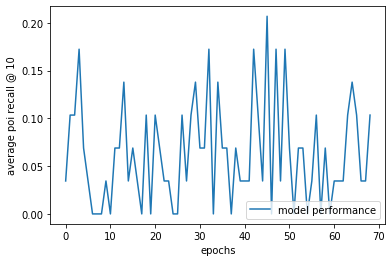

In [64]:
# plot training loss against feed samples 

import pylab

pylab.plot(np.arange(len(recall_10_poi)), recall_10_poi, label='model performance')
    
pylab.xlabel('epochs')
pylab.ylabel('average poi recall @ 10')
pylab.legend(loc='lower right')
pylab.savefig('./figures/performance_CAL.png')

pylab.show()

In [65]:
import pandas as pd

len(entropy_loss)

Training_result_pd = pd.DataFrame({
    'epoch': np.arange(1, len(entropy_loss)+1), 
    'loss': entropy_loss,
    'recall 10': recall_10_poi
})
    
Training_result_pd.to_csv('./training_results/Training_result_CAL.csv')